<a href="https://colab.research.google.com/github/Prathyushakaipa/getinto-machinelearning/blob/master/neuralnetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import os
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

In [0]:
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=0,std=1)])
train_data_set=FashionMNIST(train=True, transform=transform, root=os.getcwd(), download=True)
test_data_set=FashionMNIST(train=False, transform=transform, root=os.getcwd(), download=True)

Extracting /content/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/FashionMNIST/raw


Extracting /content/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



Extracting /content/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/FashionMNIST/raw


Extracting /content/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/FashionMNIST/raw
Processing...
Done!


In [0]:
print('Train dataset:',train_data_set)
print('Test dataset:',test_data_set)

Train dataset: Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: /content
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0, std=1)
           )
Test dataset: Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: /content
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0, std=1)
           )


In [0]:
classes=train_data_set.classes
print(len(classes))
print(classes)

10
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [0]:
train_loader=DataLoader(train_data_set,batch_size=16,shuffle=True,num_workers=4)
test_loader=DataLoader(test_data_set,batch_size=16,shuffle=False,num_workers=4)
train_iterator=iter(train_loader)
train_batch=next(train_iterator)
for item in train_batch:
  print(item.size())

torch.Size([16, 1, 28, 28])
torch.Size([16])


In [0]:
def plot_images(batch):
  img_grid=make_grid(batch[0],nrow=4)
  img_np=img_grid.numpy()
  img_np=np.transpose(img_np,(1,2,0))
  plt.figure(figsize=(8,8))
  plt.imshow(img_np)
  plt.title(batch[1])
  plt.xticks([])
  plt.yticks([])
  plt.plot()

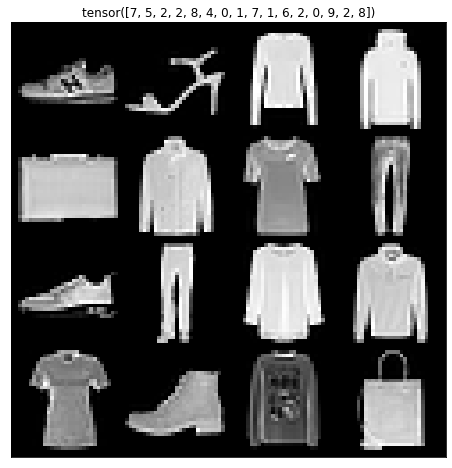

In [0]:
plot_images(train_batch)

In [0]:
flatten=nn.Flatten()
flatten(train_batch[0]).size()

torch.Size([16, 784])

In [0]:
model=nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=784,out_features=650),
    nn.ReLU(),
    nn.Linear(in_features=650,out_features=420),
    nn.ReLU(),
    nn.Linear(in_features=420,out_features=360),
    nn.ReLU(),
    nn.Linear(in_features=360,out_features=230),
    nn.ReLU(),
    nn.Linear(in_features=230,out_features=10),
    nn.Softmax(dim=1))
model

Sequential(
  (0): Flatten()
  (1): Linear(in_features=784, out_features=650, bias=True)
  (2): ReLU()
  (3): Linear(in_features=650, out_features=420, bias=True)
  (4): ReLU()
  (5): Linear(in_features=420, out_features=360, bias=True)
  (6): ReLU()
  (7): Linear(in_features=360, out_features=230, bias=True)
  (8): ReLU()
  (9): Linear(in_features=230, out_features=10, bias=True)
  (10): Softmax(dim=1)
)

In [0]:
pred_batch=model(train_batch[0])
print(pred_batch.size())

torch.Size([16, 10])


In [0]:
pred_labels=torch.argmax(pred_batch,axis=1)
print(pred_labels)

tensor([8, 7, 7, 8, 8, 8, 7, 7, 8, 8, 8, 8, 7, 7, 7, 8],
       grad_fn=<NotImplemented>)


In [0]:
loss_criterion=nn.CrossEntropyLoss()
loss_criterion(pred_batch,train_batch[1])

tensor(2.3020, grad_fn=<NllLossBackward>)

In [0]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [0]:
def evaluate_on_gpu(model,dataloader):
  with torch.no_grad():
    total,correct=0,0
    for batch in dataloader:
      images,labels=batch
      images,labels=images.to(device),labels.to(device)
      out_probs=model(images)
      out_labels=torch.argmax(out_probs,axis=1)
      total+=labels.size(0)
      correct += torch.sum(labels == out_labels).item()
    return 100* correct/total
def train_on_gpu(model,loss_criterion,optimizer,train_loader,test_loader,epochs=5):
  hist={'loss':[],
        'train_acc':[],
        'test_acc':[]}
  for epoch_num in tqdm(range(1,epochs+1),desc='Training',total=epochs):
    losses=[]
    for batch in train_loader:
      images,labels=batch
      images,labels = images.to(device),labels.to(device)
      optimizer.zero_grad()
      out = model(images)
      loss= loss_criterion(out,labels)
      losses.append(loss.item())
      loss.backward()
      optimizer.step()
    hist['loss'].append(np.array(losses).mean())
    train_acc=evaluate_on_gpu(model,train_loader)
    test_acc=evaluate_on_gpu(model,test_loader)
    hist['train_acc'].append(train_acc)
    hist['test_acc'].append(test_acc)
  fig, ax=plt.subplots(nrows=1,ncols=2,figsize=(14,7))
  ax[0].plot(range(1,epochs+1),hist['loss'],label='loss')
  ax[0].grid()
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('loss_value')
  ax[0].set_title('epochs vs loss_value')
  ax[1].plot(hist['train_acc'],'b-',label='Train accuracy')
  ax[1].plot(hist['test_acc'],'m-',label='Test accuracy')
  ax[1].grid()
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('accuracy')
  ax[1].set_title('epochs vs accuracy')
  plt.show()
  return model

In [0]:
model=nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=784,out_features=650),
    nn.ReLU(),
    nn.Linear(in_features=650,out_features=420),
    nn.ReLU(),
    nn.Linear(in_features=420,out_features=360),
    nn.ReLU(),
    nn.Linear(in_features=360,out_features=230),
    nn.ReLU(),
    nn.Linear(in_features=230,out_features=10),
    nn.Softmax(dim=1))
model=model.to(device)

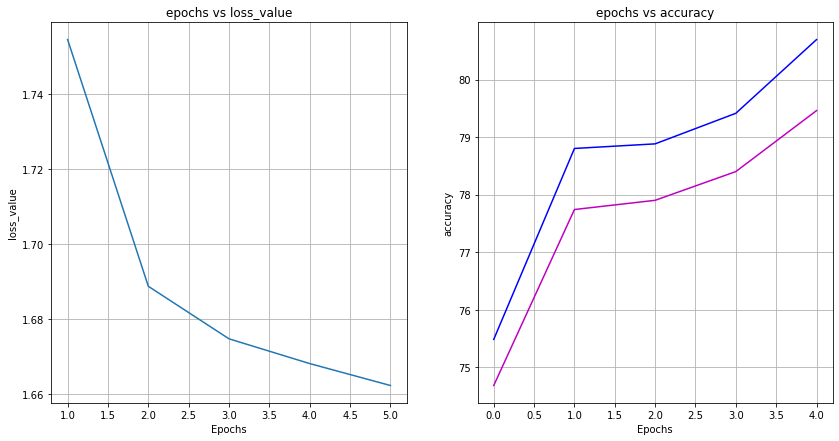

In [0]:
loss_criterion=nn.CrossEntropyLoss()
optimizer= optim.Adam(model.parameters(),lr=0.0001)
model= train_on_gpu(model, loss_criterion, optimizer, train_loader, test_loader)

In [0]:
test_imgs,test_lbls=next(iter(test_loader))
test_imgs,test_lbls=test_imgs.to(device),test_lbls.to(device)
out_probs=model(test_imgs)
out_labels=torch.argmax(out_probs,axis=1)
print('Predicted:',[classes[i] for i in out_labels])
print('Actual:',[classes[i] for i in test_lbls])

Predicted: ['Ankle boot', 'Pullover', 'Trouser', 'Trouser', 'Shirt', 'Trouser', 'Shirt', 'Shirt', 'Sandal', 'Sneaker', 'Pullover', 'Sandal', 'Bag', 'Dress', 'Pullover', 'Trouser']
Actual: ['Ankle boot', 'Pullover', 'Trouser', 'Trouser', 'Shirt', 'Trouser', 'Coat', 'Shirt', 'Sandal', 'Sneaker', 'Coat', 'Sandal', 'Sneaker', 'Dress', 'Coat', 'Trouser']


In [0]:
print('Test acc:',evaluate_on_gpu(model,test_loader))
print('Train acc:',evaluate_on_gpu(model,train_loader))

Test acc: 79.46
Train acc: 80.695
